In [1]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import random
import math

In [2]:
# Configurar dispositivo CUDA si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [3]:
class BasuraDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, img_size=28, val_split=0.2, test_split=0.1):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.val_split = val_split
        self.test_split = test_split
        self.classes = ['CascaraManzana', 'EnvoltorioSnacks', 'Facturas', 'GuantesLatex', 'Hojas']
        
        # Transformaciones para imágenes COLOR (3 canales RGB)
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),  # Redimensionar a 28x28
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalización para RGB
        ])

    def setup(self, stage=None):
        # Cargar dataset completo
        full_dataset = datasets.ImageFolder(
            root=self.data_dir,
            transform=self.transform
        )
        
        # Dividir en train, val, test
        dataset_size = len(full_dataset)
        val_size = int(dataset_size * self.val_split)
        test_size = int(dataset_size * self.test_split)
        train_size = dataset_size - val_size - test_size
        
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size]
        )
        
        # Guardar las clases
        self.classes = full_dataset.classes

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=0)

In [4]:
class AttnBasuraDataset(Dataset):
    def __init__(self, dataset, patch_size=(7, 7)):
        self.dataset = dataset
        self.patch_size = patch_size
        self.patches_per_side = 28 // patch_size[0]  # 28/7 = 4 patches por lado
        self.num_patches = self.patches_per_side * self.patches_per_side  # 16 patches total

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        # img shape: [3, 28, 28] (RGB)
        # Crear patches de 7x7 para cada canal
        c, h, w = img.shape
        patches_per_channel = []
        
        for channel in range(c):
            channel_img = img[channel:channel+1, :, :]  # [1, 28, 28]
            patches = channel_img.unfold(1, self.patch_size[0], self.patch_size[0]).unfold(2, self.patch_size[1], self.patch_size[1])
            patches = patches.contiguous().view(self.num_patches, self.patch_size[0] * self.patch_size[1])
            patches_per_channel.append(patches)
        
        # Combinar patches de todos los canales: [16, 49*3] = [16, 147]
        all_patches = torch.cat(patches_per_channel, dim=1)
        
        return all_patches, label

class BasuraTransformerDataModule(BasuraDataModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.patch_size = (7, 7)

    def setup(self, stage=None):
        super().setup(stage)
        
        # Convertir datasets a formato de patches
        self.train_dataset = AttnBasuraDataset(self.train_dataset, self.patch_size)
        self.val_dataset = AttnBasuraDataset(self.val_dataset, self.patch_size)
        self.test_dataset = AttnBasuraDataset(self.test_dataset, self.patch_size)

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = n_embd // n_heads
        
        # Asegurarse de que n_embd es divisible por n_heads
        assert n_embd % n_heads == 0, "n_embd must be divisible by n_heads"
        
        self.key = nn.Linear(n_embd, n_embd)
        self.query = nn.Linear(n_embd, n_embd)
        self.value = nn.Linear(n_embd, n_embd)
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, L, F = x.size()
        
        # Proyectar y dividir en heads
        k = self.key(x).view(B, L, self.n_heads, F // self.n_heads).transpose(1, 2)
        q = self.query(x).view(B, L, self.n_heads, F // self.n_heads).transpose(1, 2)
        v = self.value(x).view(B, L, self.n_heads, F // self.n_heads).transpose(1, 2)
        
        # Calcular atención
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        att = self.dropout(att)
        
        # Aplicar atención a los valores
        y = att @ v
        
        # Reensamblar
        y = y.transpose(1, 2).contiguous().view(B, L, F)
        return self.proj(y)

class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.1)
        )
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Atención con residual connection
        x_attn = self.attn(self.ln1(x))
        x = x + self.dropout(x_attn)
        
        # MLP con residual connection
        x_mlp = self.mlp(self.ln2(x))
        x = x + self.dropout(x_mlp)
        
        return x


class BasuraTransformer(pl.LightningModule):
    def __init__(self, n_input=147, n_embd=128, seq_len=16, n_heads=4, n_layers=3, num_classes=5):
        super().__init__()
        self.save_hyperparameters()
        
        # Historial de métricas
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        
        # Embedding de posición
        self.pos_emb = nn.Parameter(torch.zeros(1, seq_len, n_embd))
        nn.init.normal_(self.pos_emb, std=0.02)
        
        # Embedding de entrada
        self.inp_emb = nn.Linear(n_input, n_embd)
        
        # Capas Transformer
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(n_embd, n_heads) for _ in range(n_layers)
        ])
        
        # Capa de normalización final
        self.ln_final = nn.LayerNorm(n_embd)
        
        # Clasificador
        self.fc = nn.Linear(n_embd * seq_len, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, L, F = x.size()
        x = self.inp_emb(x)
        x = x + self.pos_emb[:, :L, :]
        x = self.dropout(x)
        
        for block in self.transformer_blocks:
            x = block(x)
        
        x = self.ln_final(x)
        x = x.reshape(B, -1)
        return self.fc(x)

    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, dim=1) == y).float().mean()
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        
        # Guardar métricas para gráficos
        if batch_idx == 0:  # Solo guardar una vez por epoch
            self.train_losses.append(loss.item())
            self.train_accs.append(acc.item())
            
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        # Guardar métricas para gráficos
        if batch_idx == 0:  # Solo guardar una vez por epoch
            self.val_losses.append(loss.item())
            self.val_accs.append(acc.item())
            
        return loss

    def test_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

    def predict(self, x):
        with torch.no_grad():
            y_hat = self(x)
            return torch.argmax(y_hat, dim=1)

In [16]:
# Configurar paths
# Configurar paths
data_dir = "DataasetBasura"  # Ajusta este path según tu estructura

# Inicializar data module
dm = BasuraTransformerDataModule(
    data_dir=data_dir,
    batch_size=32,
    img_size=28,
    val_split=0.15,
    test_split=0.15
)

dm.setup()

# Ver información del dataset
print(f"Clases: {dm.classes}")
print(f"Train samples: {len(dm.train_dataset)}")
print(f"Val samples: {len(dm.val_dataset)}")
print(f"Test samples: {len(dm.test_dataset)}")

# Verificar la forma de los datos
sample_loader = dm.train_dataloader()
sample_batch = next(iter(sample_loader))
patches, labels = sample_batch
print(f"Shape de patches: {patches.shape}")  # Debería ser [batch_size, 16, 147]
print(f"Shape de labels: {labels.shape}")

# Inicializar modelo con los parámetros CORRECTOS
model = BasuraTransformer(
    n_input=147,      # 7x7x3 = 147 (7x7 patches con 3 canales RGB)
    n_embd=128,       # Dimensión de embedding
    seq_len=16,       # 16 patches (4x4)
    n_heads=4,        # 4 cabezas de atención
    n_layers=3,       # 3 capas transformer
    num_classes=5     # 5 clases
)

# Verificar que el modelo puede procesar los datos
test_output = model(patches)
print(f"Output shape: {test_output.shape}")  # Debería ser [batch_size, 5]

# Mover modelo a GPU
model.to(device)
print(f"Modelo en: {next(model.parameters()).device}")

# Configurar trainer
trainer = pl.Trainer(
    max_epochs=20,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    log_every_n_steps=10,
    enable_checkpointing=True,
    deterministic=True
)

# Entrenar
trainer.fit(model, dm)

# Evaluar
trainer.test(model, dm)


Clases: ['CascaraManzana', 'EnvoltorioSnacks', 'Facturas', 'GuantesLatex', 'Hojas']
Train samples: 35664
Val samples: 7641
Test samples: 7641


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type       | Params | Mode 
----------------------------------------------------------
0 | inp_emb            | Linear     | 18.9 K | train
1 | transformer_blocks | ModuleList | 594 K  | train
2 | ln_final           | LayerNorm  | 256    | train
3 | fc                 | Linear     | 10.2 K | train
4 | dropout            | Dropout    | 0      | train
  | other params       | n/a        | 2.0 K  | n/a  
----------------------------------------------------------
626 K     Trainable params
0         Non-trainable params
626 K     Total params
2.505     Total estimated model params size (MB)
50        Modules

Shape de patches: torch.Size([32, 16, 147])
Shape de labels: torch.Size([32])
Output shape: torch.Size([32, 5])
Modelo en: cpu
Epoch 19: 100%|██████████| 1115/1115 [02:45<00:00,  6.74it/s, v_num=13, train_loss=0.0795, train_acc=0.938, val_loss=0.0657, val_acc=0.984]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1115/1115 [02:45<00:00,  6.74it/s, v_num=13, train_loss=0.0795, train_acc=0.938, val_loss=0.0657, val_acc=0.984]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 239/239 [00:37<00:00,  6.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9901845455169678
        test_loss           0.0351652130484581
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0351652130484581, 'test_acc': 0.9901845455169678}]

In [17]:
# Verificación adicional de dimensiones
print("=== VERIFICACIÓN DE DIMENSIONES ===")

# Verificar dataset
sample_patches, sample_label = dm.train_dataset[0]
print(f"Sample patch shape: {sample_patches.shape}")  # Debería ser [16, 147]

# Verificar modelo
model.eval()
with torch.no_grad():
    test_input = torch.randn(2, 16, 147)  # Batch size 2
    test_output = model(test_input)
    print(f"Test input shape: {test_input.shape}")
    print(f"Test output shape: {test_output.shape}")

# Verificar que todas las capas tienen las dimensiones correctas
print("\n=== VERIFICACIÓN DE CAPAS ===")
print(f"Input embedding: {model.inp_emb.weight.shape}")  # Debería ser [128, 147]
print(f"Position embedding: {model.pos_emb.shape}")      # Debería ser [1, 16, 128]
print(f"Final classifier: {model.fc.weight.shape}")      # Debería ser [5, 2048] (128*16=2048)

=== VERIFICACIÓN DE DIMENSIONES ===
Sample patch shape: torch.Size([16, 147])
Test input shape: torch.Size([2, 16, 147])
Test output shape: torch.Size([2, 5])

=== VERIFICACIÓN DE CAPAS ===
Input embedding: torch.Size([128, 147])
Position embedding: torch.Size([1, 16, 128])
Final classifier: torch.Size([5, 2048])


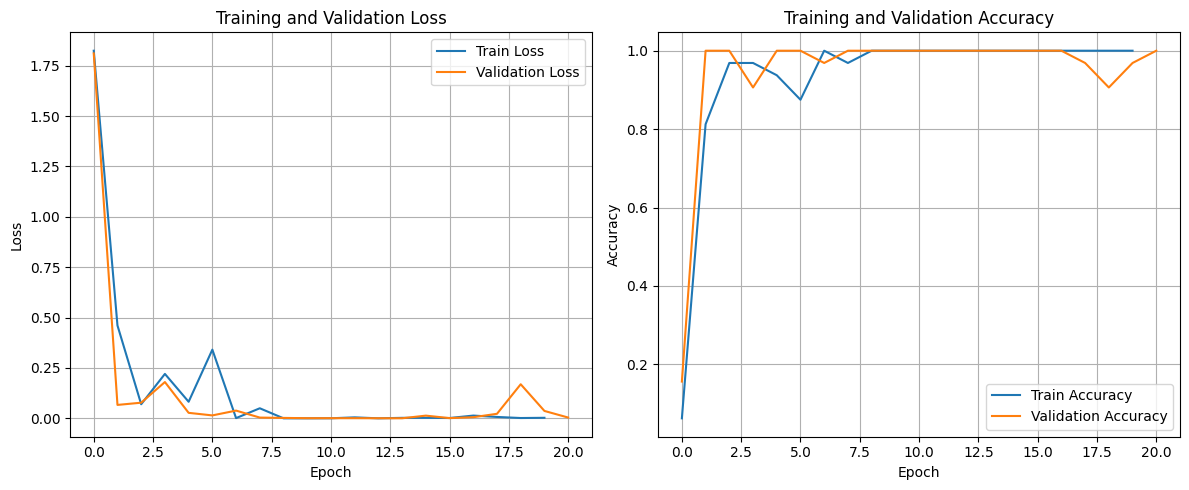

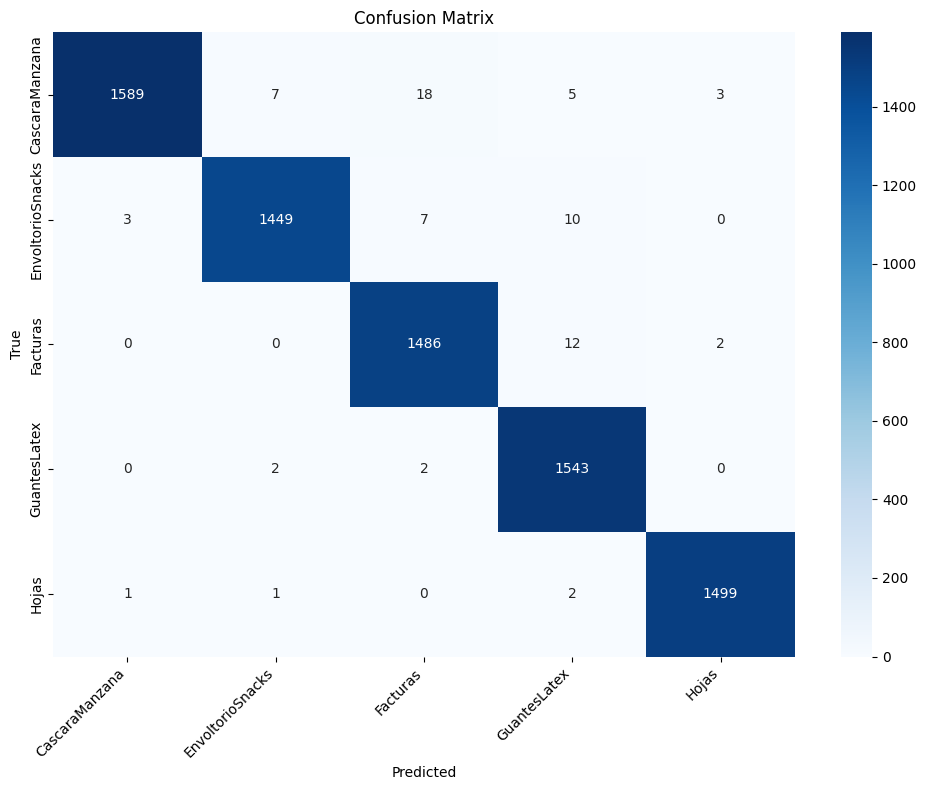

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_training_metrics(model, classes):
    # Obtener métricas del modelo
    train_losses = model.train_losses
    val_losses = model.val_losses
    train_accs = model.train_accs
    val_accs = model.val_accs
    
    # Crear figura para pérdidas
    plt.figure(figsize=(12, 5))
    
    # Gráfico de pérdidas
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, dataloader, classes, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            patches, labels = batch
            patches = patches.to(device)
            labels = labels.to(device)
            
            outputs = model(patches)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    
    # Visualizar matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return cm

# Uso del código
# Asegúrate de que el modelo y el datamodule estén definidos y entrenados
# Llamar a las funciones de visualización
plot_training_metrics(model, dm.classes)
cm = plot_confusion_matrix(model, dm.test_dataloader(), dm.classes, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.7647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49019605..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.7647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64705884..0.21568632].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216

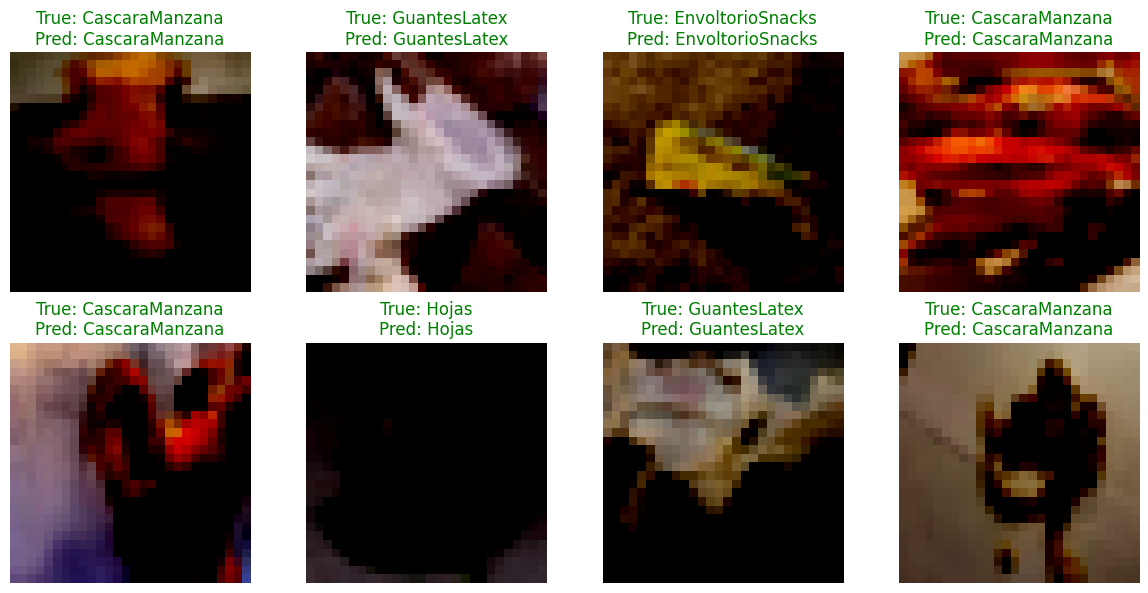

In [20]:
# Obtener batch de validación
val_loader = dm.val_dataloader()
imgs, labels = next(iter(val_loader))

# Mover datos al mismo dispositivo que el modelo
device = next(model.parameters()).device
imgs = imgs.to(device)
labels = labels.to(device)

# Predecir
model.eval()
with torch.no_grad():
    preds = model.predict(imgs)

# Mover de vuelta a CPU para visualización
imgs_cpu = imgs.cpu()
labels_cpu = labels.cpu()
preds_cpu = preds.cpu()

# Visualizar algunas muestras
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    # Reconstruir imagen desde patches (para visualización)
    # Necesitamos obtener la imagen original, no los patches
    # Para esto, usaremos el dataset original sin transformar para visualización
    
    # Cargar transformación solo para visualización (sin normalizar)
    transform_vis = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])
    
    # Obtener la imagen original del dataset de validación
    original_idx = dm.val_dataset.indices[i] if hasattr(dm.val_dataset, 'indices') else i
    original_img, _ = dm.val_dataset.dataset[original_idx]
    
    # Visualizar imagen original
    axes[i].imshow(original_img.permute(1, 2, 0))  # Cambiar de [C, H, W] a [H, W, C]
    
    true_label = dm.classes[labels_cpu[i].item()]
    pred_label = dm.classes[preds_cpu[i].item()]
    color = 'green' if labels_cpu[i] == preds_cpu[i] else 'red'
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color=color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [22]:
# Guardar modelo
torch.save(model.state_dict(), 'basura_transformer_v3.pth')

# Para cargar después:
# model = BasuraTransformer(...)
# model.load_state_dict(torch.load('basura_transformer.pth'))
# model.to(device)